# Loading library and defining paths

In [1]:
import sys
sys.path.append("../")

In [2]:
# Importing libraries
import json
import openai
import time
import os
from unstructured.partition.auto import partition_pdf
import pandas as pd
import time
import random
import pandas as pd

In [3]:
# Add your Openai key
openai.api_key = ""
os.getcwd()

'c:\\GBW_MyDownloads\\chatgpt\\chatgpt_REMBI\\examples'

In [11]:
# Creation of an empty dataframe
columns = ["Manuscript", "ELN", "ManGO Metadata", "All sources"]
indexes = ["Title", "Authors", "Topic","Methodology", "Repository"]
df = pd.DataFrame(columns=columns, index=indexes)
print(df)

            Manuscript  ELN ManGO Metadata All sources
Title              NaN  NaN            NaN         NaN
Authors            NaN  NaN            NaN         NaN
Topic              NaN  NaN            NaN         NaN
Methodology        NaN  NaN            NaN         NaN
Repository         NaN  NaN            NaN         NaN


# Preprocessing files

In [13]:
#Conversion of a pdf file to a text file
main_pdf=r"..\input\What we can learn from deep space communication for reproducible BioImage analysis-20.pdf"
elements = partition_pdf(filename=main_pdf, infer_table_structure=False)
with open(r'..\preprocessed_files\main.txt',"w") as main_file:
    for element in elements:
        main_file.write(str(element))
        main_file.write("\n")


In [18]:
#Merging two metadata file in one json file
json_merged=[]
with open(r"..\input\study_bia.json", 'r') as file1:
    data1 = json.load(file1)
    json_merged.append(data1)
# Read the content of the second JSON file
with open(r'..\input\analysis.json', 'r') as file2:
    data2 = json.load(file2)
    json_merged.append(data2)


# Write the merged data to a new JSON file
with open(r'..\preprocessed_files\merged.json', 'w') as merged_file:
    json.dump(json_merged, merged_file,indent=4)

## Querying with CHATGPT 4

In [6]:
# function to interact with chatgpt through the API
def make_chat_request(query, prompt):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": query},
                {"role": "user", "content": prompt},
            ],
        )
        return response.choices[0].message['content']
    except openai.error.OpenAIError as e:
        print(f"An error occurred: {e}")
        return None


In [7]:
# function to delay the interaction to avoid the token limit of chatgpt
def exponential_backoff_retry(query, prompt, max_retries=10):
    retry_count = 0
    while retry_count < max_retries:
        response = make_chat_request(query, prompt)
        if response is not None:
            return response
        else:
            retry_count += 1
            wait_time = 2 ** retry_count  # Exponential backoff formula
            wait_time += random.uniform(0, 1)  # Add some randomness
            print(f"Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
    
    print("Max retries reached. Unable to get a response.")
    return None

In [56]:
def parsing_response_chatgpt(response_string):
    """ splitting response in a list and removing keyword before semi-colon"""
    lines = response_string.split('\n')
    lines_cleaned=[]
    for line in lines:
        if not line:
            continue
        colon_index = line.find(":")
        if colon_index != -1:
            lines_cleaned.append(line[colon_index + 1:].strip())
    return lines_cleaned

In [14]:
# querying the main file
with open(r"..\preprocessed_files\main.txt") as file:
    combined_content=file.read()
question="Extract: title, authors, main topic, methodology and github repository"
response = exponential_backoff_retry(question, combined_content)
if response:
    print(f"ChatGPT Response: {response}")
else:
    print("Failed to get a response after multiple retries.")
df['Manuscript']= parsing_response_chatgpt(response)

ChatGPT Response: Title: Proofreading Approach to Improve Reproducibility in BioImaging Metadata Using AI (Artificial Intelligence) Language Models

Authors: Tatiana Woller, Christopher J. Cawthorne, Romain Raymond, Agnes Slootmaekers, Ingrid Barcena Roig, Alex Botzki, Sebastian Munck

Main Topic: The paper discusses the challenge of maintaining reproducibility in BioImage data, similar to the challenges in deep space communications. It suggests the implementation of AI language model proofreading to improve error correction and consequently, the fidelity of the data.

Methodology: The authors have created a workflow where the Large Language Model GPT-4 reads a lab notebook entry, a corresponding ManGO metadata file, and this publication to look for a list of keywords, and checks them for consistency across these metadata sources. Error correction is then performed by highlighting gaps and contradictions.

GitHub Repository: https://github.com/vib-bic-training/Reproducibility_RDM.git


In [17]:
# querying the ELN/ readme file
with open(r"..\input\README.txt") as file:
   combined_content=file.read()
question="Extract: title, authors, main topic, methodology and github repository"
response = exponential_backoff_retry(question, combined_content)
if response:
    print(f"ChatGPT Response: {response}")
else:
    print("Failed to get a response after multiple retries.")
df['ELN']= parsing_response_chatgpt(response)

ChatGPT Response: Title: What we can learn from deep space communication for reproducible BioImaging and data analysis

Authors: Not mentioned in the extract provided.

Main Topic: The project deals with reproducible BioImaging and data analysis, adopting techniques from deep space communication. It involves running scripts interactively with GPT-4 through an API.

Methodology: The scripts for this project are executed using Python 3.10. Dependencies are listed in the requirements_sm.txt file. The main interaction with GPT-4 is done via an API for which an API key is required from OpenAI. The accepted input formats for the scripts are pdf, txt, and json files.

Github repository: The Github repository for the scripts and config files is found at https://github.com/vib-bic-training/Reproducibility_RDM. The project is based on https://github.com/kbressem/gpt4-structured-reporting.


In [19]:
# querying the metadata file
with open(r"..\preprocessed_files\merged.json") as json_file:
    json_data=json.load(json_file)
question="Extract: title, authors, main topic, methodology and github repository"
response = exponential_backoff_retry(question, json.dumps(json_data))
if response:
    print(f"ChatGPT Response: {response}")
else:
    print("Failed to get a response after multiple retries.")
df['ManGO Metadata']= parsing_response_chatgpt(response)

ChatGPT Response: Title: What we can learn from deep space communication for reproducible BioImaging and data analysis 

Authors: Tatiana Woller, Christopher Cawthorne, Romain Raymond Agnes Slootmaekers, Ingrid Barcena Roig, Alex Botzki, Sebastian Munck

Main Topic: The study discusses learning from deep space communication to improve the reproducibility of BioImaging and data analysis.

Methodology: The research uses a Large Language Model (GPT-4) and follows the REMBI standard for their analyses.

Github Repository: The code and data used for the study can be found at https://github.com/vib-bic-training/Reproducibility_RDM.git.


In [20]:
df

,Manuscript,ELN,ManGO Metadata,All sources
Title,Proofreading Approach to Improve Reproducibili...,What we can learn from deep space communicatio...,What we can learn from deep space communicatio...,NaN
Authors,"Tatiana Woller, Christopher J. Cawthorne, Roma...",Not mentioned in the extract provided.,"Tatiana Woller, Christopher Cawthorne, Romain ...",NaN
Topic,The paper discusses the challenge of maintaini...,The project deals with reproducible BioImaging...,The study discusses learning from deep space c...,NaN
Methodology,The authors have created a workflow where the ...,The scripts for this project are executed usin...,The research uses a Large Language Model (GPT-...,NaN
Repository,https://github.com/vib-bic-training/Reproducib...,The Github repository for the scripts and conf...,The code and data used for the study can be fo...,NaN


In [13]:
# querying the main text and the readme file
file_paths = [r"..\preprocessed_files\main.txt", r"..\input\README.txt"]
file_contents = []

for file_path in file_paths:
    with open(file_path, "r") as file:
        file_contents.append(file.read())

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Extract: title, authors, main topic, methodology and github repository"},
]

for content in file_contents:
    messages.append({"role": "user", "content": content})

response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=messages,
)

assistant_reply = response['choices'][0]['message']['content']
print(assistant_reply)

Title: "What we can learn from deep space communication for reproducible BioImage analysis"

Authors: Tatiana Woller, Chris Cawthorne, Romain Raymond Agnes Slootmaekers, Ingrid Barcena Roig, Alex Botzki, Sebastian Munck

Main Topic: The manuscript focuses on how principles learned from deep space communication could be implemented for creating reproducible BioImage analysis, essentially utilising AI language models for performing proofreading and enhancing error correction for bioimaging data.

Methodology: The authors describe a proof of concept wherein a Large Language Model (GPT-4 in this case) is used to read and check the consistency in a lab notebook entry, a ManGO metadata file, and the paper itself. Once the required information is extracted, gaps and potential errors are identified and highlighted. 

GitHub Repository: https://github.com/vib-bic-training/Reproducibility_RDM.git


In [25]:
#querying the main text, the readme file and the metadata file
file_paths = [r"..\preprocessed_files\main.txt", r"..\input\README.txt", r"..\preprocessed_files\merged.json"]
file_contents = []

for file_path in file_paths:
    if file_path.endswith(".txt"):
        with open(file_path, "r") as file:
            file_contents.append(file.read())
    elif file_path.endswith(".json"):
        with open(file_path, "r") as json_file:
            file_contents.append(json.dumps(json.load(json_file)))
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Extract: title, authors, main topic, methodology and github repository"},
]

for content in file_contents:
    messages.append({"role": "user", "content": content})

response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=messages,
)
assistant_reply = response['choices'][0]['message']['content']
print(assistant_reply)

Title: What we can learn from deep space communication for reproducible BioImaging and data analysis

Authors: Tatiana Woller, Christopher Cawthorne, Romain Raymond Agnes Slootmaekers, Ingrid Barcena Roig, Alex Botzki, Sebastian Munck

Main Topic: This paper discusses the issues regarding reproducibility in BioImage and data analysis. It offers a solution using the concept of error correction protocols used in space communication. The authors propose the use of AI language model proofreading to digest redundant metadata entries, visualize the differences, and correct errors. This method aims to increase metadata consistency, and improve overall documentation for higher reproducibility and reusability.

Methodology: The authors implemented a workflow, where the GPT-4 Language Model reads different metadata sources, including a lab notebook entry, the corresponding ManGO metadata file, and this publication. These sources are searched for specific keywords to see their consistency. Then, 

In [57]:
df['All sources']= parsing_response_chatgpt(assistant_reply)

In [58]:
df

,Manuscript,ELN,ManGO Metadata,All sources
Title,Proofreading Approach to Improve Reproducibili...,What we can learn from deep space communicatio...,What we can learn from deep space communicatio...,What we can learn from deep space communicatio...
Authors,"Tatiana Woller, Christopher J. Cawthorne, Roma...",Not mentioned in the extract provided.,"Tatiana Woller, Christopher Cawthorne, Romain ...","Tatiana Woller, Christopher Cawthorne, Romain ..."
Topic,The paper discusses the challenge of maintaini...,The project deals with reproducible BioImaging...,The study discusses learning from deep space c...,This paper discusses the issues regarding repr...
Methodology,The authors have created a workflow where the ...,The scripts for this project are executed usin...,The research uses a Large Language Model (GPT-...,"The authors implemented a workflow, where the ..."
Repository,https://github.com/vib-bic-training/Reproducib...,The Github repository for the scripts and conf...,The code and data used for the study can be fo...,[https://github.com/vib-bic-training/Reproduci...


In [59]:
transposed_df=df.transpose()

In [60]:
transposed_df.to_csv(r"../output/report_table.csv")

# Comparing the extracted information using Spacy

In [61]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from collections import Counter
from heapq import nlargest
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [62]:
nlp=spacy.load("en_core_web_lg")

In [63]:
output = pd.read_csv(r"..\output\report_table.csv")

In [64]:
output.set_index("Unnamed: 0",inplace=True)

In [65]:
output

,Title,Authors,Topic,Methodology,Repository
Unnamed: 0,,,,,
Manuscript,Proofreading Approach to Improve Reproducibili...,"Tatiana Woller, Christopher J. Cawthorne, Roma...",The paper discusses the challenge of maintaini...,The authors have created a workflow where the ...,https://github.com/vib-bic-training/Reproducib...
ELN,What we can learn from deep space communicatio...,Not mentioned in the extract provided.,The project deals with reproducible BioImaging...,The scripts for this project are executed usin...,The Github repository for the scripts and conf...
ManGO Metadata,What we can learn from deep space communicatio...,"Tatiana Woller, Christopher Cawthorne, Romain ...",The study discusses learning from deep space c...,The research uses a Large Language Model (GPT-...,The code and data used for the study can be fo...
All sources,What we can learn from deep space communicatio...,"Tatiana Woller, Christopher Cawthorne, Romain ...",This paper discusses the issues regarding repr...,"The authors implemented a workflow, where the ...",[https://github.com/vib-bic-training/Reproduci...


In [66]:
def calculate_similarity(text1: str, text2:str):
    """ To compute the cosine similarity between two strings"""
    doc1 = nlp(text1)
    doc2 = nlp(text2)
    return doc1.similarity(doc2)

In [67]:
def df_similarity_score( dataframe_out,keyw :str):
    """ Returns a dataframe with cosine similarity"""
    dico=dict()
    for i in range(len(dataframe_out[keyw])):
        for j in range(i + 1, len(dataframe_out[keyw])):
            text1 =  dataframe_out.iloc[i, dataframe_out.columns.get_loc(keyw)]  
            text2 = dataframe_out.iloc[j, dataframe_out.columns.get_loc(keyw)]  
            key = lambda i, j: str(dataframe_out.iloc[i, 0]) + " vs " + str(dataframe_out.iloc[j, 0])
            dico[key]=calculate_similarity(text1, text2)
    test=pd.DataFrame.from_dict(dico,orient='index', columns=[keyw])
    new_index = ["Manuscript  vs  ELN", "Manuscript  vs  ManGO Metadata", "Manuscript  vs  All sources", "ELN  vs  ManGO Metadata","ELN  vs  All sources", "ManGO Metadata  vs  All sources"]
    test.index=new_index
    return test

In [68]:
df_title=df_similarity_score(output, "Title")
df_authors=df_similarity_score(output, "Authors")
df_topic=df_similarity_score(output, "Topic")
df_method=df_similarity_score(output, "Methodology")

In [69]:
def find_url(URL):
  """ To extract the url using regular expression"""
  test=set()
  url = re.findall(r"https?://\S+|www\.\S+",URL) 
  return url

In [75]:
def df_similarity_score_url( dataframe_out,keyw :str):
    """ Save the similarity score for the repository keyword"""
    index=["Manuscript  vs  ELN", "Manuscript  vs  ManGO Metadata", "Manuscript  vs  All sources", "ELN  vs  ManGO Metadata","ELN  vs  All sources", "ManGO Metadata  vs  All sources"]
    values=[]
    for i in range(len(dataframe_out[keyw])):
        for j in range(i + 1, len(dataframe_out[keyw])):
            text1 = find_url(dataframe_out.iloc[i, dataframe_out.columns.get_loc(keyw)] )
            text2 = find_url(dataframe_out.iloc[j, dataframe_out.columns.get_loc(keyw)] )
            tfidf_vectorizer = TfidfVectorizer()

        # Fit and transform the URLs to create TF-IDF vectors
            if len(text1)>1:
                text1=text1[0]
            elif len(text2)>1:
                text2=text2[0]
            elif len(text1)==1 and len(text2)==1:
                text1=str(text1)
                text2=str(text2)
            tfidf_matrix = tfidf_vectorizer.fit_transform([str(text1), str(text2)])
        # Calculate the cosine similarity between the TF-IDF vectors
            cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])
        # The result is a similarity matrix, get the cosine similarity value
            key= str(dataframe_out.iloc[i,0]) + " vs " + str(dataframe_out.iloc[j,0])
            values.append(cosine_sim[0][0])
    test=pd.DataFrame({'Repository': values}, index=index)
    return test

In [76]:
df_repo=df_similarity_score_url(output, "Repository")

In [77]:
df_output=pd.concat([df_title,df_authors,df_topic,df_method,df_repo],axis=1)

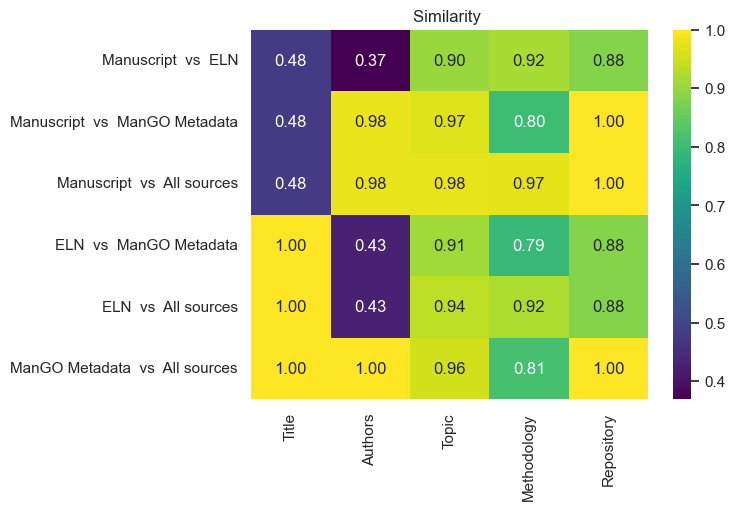

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualization of the similarity score as a heatmap
label=["Manuscript  vs  ELN", "Manuscript  vs  ManGO Metadata", "Manuscript  vs  All sources", "ELN  vs  ManGO Metadata","ELN  vs  All sources", "ManGO Metadata  vs  All sources"]
label2=["Title","Authors","Topic","Methodology", "Repository"]
sns.set()
sns.heatmap(df_output, annot=True, fmt=".2f", cmap="viridis", xticklabels=label2, yticklabels=label)
plt.title("Similarity ")
plt.show()